In [ ]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

## Load data: BSDS500 dataset

### Download dataset

We use the built-in `keras.utils.get_file` utility to retrieve the dataset.

In [ ]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

We create training and validation datasets via `image_dataset_from_directory`.

In [ ]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


We rescale the images to take values in the range [0, 1].

In [ ]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

Let's visualize a few sample images:

In [ ]:
"""for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))"""

'for batch in train_ds.take(1):\n    for img in batch:\n        display(array_to_img(img))'

We prepare a dataset of test image paths that we will use for
visual evaluation at the end of this example.

In [ ]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

## Crop and resize images

Let's process image data.
First, we convert our images from the RGB color space to the
[YUV colour space](https://en.wikipedia.org/wiki/YUV).

For the input data (low-resolution images),
we crop the image, retrieve the `y` channel (luninance),
and resize it with the `area` method (use `BICUBIC` if you use PIL).
We only consider the luminance channel
in the YUV color space because humans are more sensitive to
luminance change.

For the target data (high-resolution images), we just crop the image
and retrieve the `y` channel.

In [ ]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

Let's take a look at the input and target data.

In [ ]:
"""for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))"""

'for batch in train_ds.take(1):\n    for img in batch[0]:\n        display(array_to_img(img))\n    for img in batch[1]:\n        display(array_to_img(img))'

## Build a model

Compared to the paper, we add one more layer and we use the `relu` activation function
instead of `tanh`.
It achieves better performance even though we train the model for fewer epochs.

In [ ]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


## Define utility functions

We need to define several utility functions to monitor our results:

- `plot_results` to plot an save an image.
- `get_lowres_image` to convert an image to its low-resolution version.
- `upscale_image` to turn a low-resolution image to
a high-resolution version reconstructed by the model.
In this function, we use the `y` channel from the YUV color space
as input to the model and then combine the output with the
other channels to obtain an RGB image.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [ ]:
import cv2
import numpy as np
import math
import sys, time

def u(s, a):

    if (abs(s) >= 0) & (abs(s) <= 1):
        return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1

    elif (abs(s) > 1) & (abs(s) <= 2):
        return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
    return 0

def padding(img, H, W, C):
    zimg = np.zeros((H+4, W+4, C))
    zimg[2:H+2, 2:W+2, :C] = img

    # Pad the first/last two col and row
    zimg[2:H+2, 0:2, :C] = img[:, 0:1, :C]
    zimg[H+2:H+4, 2:W+2, :] = img[H-1:H, :, :]
    zimg[2:H+2, W+2:W+4, :] = img[:, W-1:W, :]
    zimg[0:2, 2:W+2, :C] = img[0:1, :, :C]

    # Pad the missing eight points
    zimg[0:2, 0:2, :C] = img[0, 0, :C]
    zimg[H+2:H+4, 0:2, :C] = img[H-1, 0, :C]
    zimg[H+2:H+4, W+2:W+4, :C] = img[H-1, W-1, :C]
    zimg[0:2, W+2:W+4, :C] = img[0, W-1, :C]

    return zimg

# Bicubic operation
def bicubic(img, ratio, a):

	# Get image size
	H, W, C = img.shape

	# Here H = Height, W = weight,
	# C = Number of channels if the
	# image is coloured.
	img = padding(img, H, W, C)

	# Create new image
	dH = math.floor(H*ratio)
	dW = math.floor(W*ratio)

	# Converting into matrix
	dst = np.zeros((dH, dW, 3))

	# np.zeroes generates a matrix
	# consisting only of zeroes
	# Here we initialize our answer
	# (dst) as zero

	h = 1/ratio

	print('Start bicubic interpolation')
	print('It will take a little while...')
	inc = 0

	for c in range(C):
		for j in range(dH):
			for i in range(dW):

				# Getting the coordinates of the
				# nearby values
				x, y = i * h + 2, j * h + 2

				x1 = 1 + x - math.floor(x)
				x2 = x - math.floor(x)
				x3 = math.floor(x) + 1 - x
				x4 = math.floor(x) + 2 - x

				y1 = 1 + y - math.floor(y)
				y2 = y - math.floor(y)
				y3 = math.floor(y) + 1 - y
				y4 = math.floor(y) + 2 - y

				# Considering all nearby 16 values
				mat_l = np.matrix([[u(x1, a), u(x2, a), u(x3, a), u(x4, a)]])
				mat_m = np.matrix([[img[int(y-y1), int(x-x1), c],
									img[int(y-y2), int(x-x1), c],
									img[int(y+y3), int(x-x1), c],
									img[int(y+y4), int(x-x1), c]],
								[img[int(y-y1), int(x-x2), c],
									img[int(y-y2), int(x-x2), c],
									img[int(y+y3), int(x-x2), c],
									img[int(y+y4), int(x-x2), c]],
								[img[int(y-y1), int(x+x3), c],
									img[int(y-y2), int(x+x3), c],
									img[int(y+y3), int(x+x3), c],
									img[int(y+y4), int(x+x3), c]],
								[img[int(y-y1), int(x+x4), c],
									img[int(y-y2), int(x+x4), c],
									img[int(y+y3), int(x+x4), c],
									img[int(y+y4), int(x+x4), c]]])
				mat_r = np.matrix(
					[[u(y1, a)], [u(y2, a)], [u(y3, a)], [u(y4, a)]])

				# Here the dot function is used to get the dot
				# product of 2 matrices
				dst[j, i, c] = np.dot(np.dot(mat_l, mat_m), mat_r)

	# If there is an error message, it
	# directly goes to stderr
	sys.stderr.write('\n')

	# Flushing the buffer
	sys.stderr.flush()
	return dst


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = bicubic(input, )

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

(481, 321) 480 321
Start bicubic interpolation
It will take a little while...


PSNR of low resolution image and high resolution image is 30.0157
PSNR of predict and high resolution is 27.8988


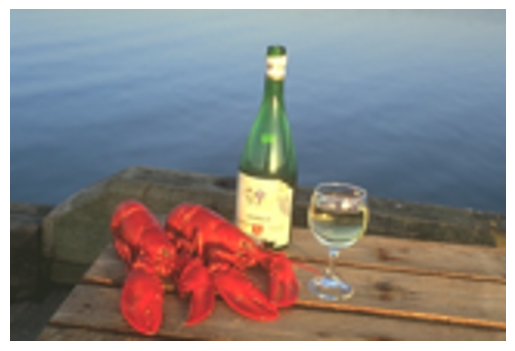

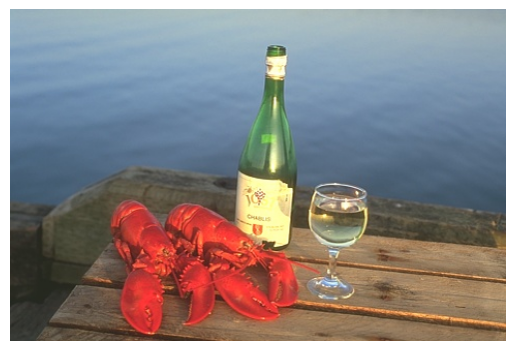

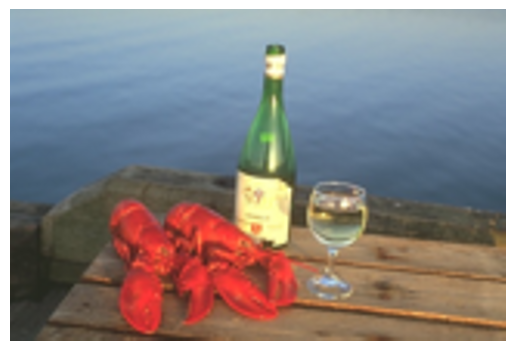

(481, 321) 480 321
Start bicubic interpolation
It will take a little while...


PSNR of low resolution image and high resolution image is 25.1103
PSNR of predict and high resolution is 22.3278


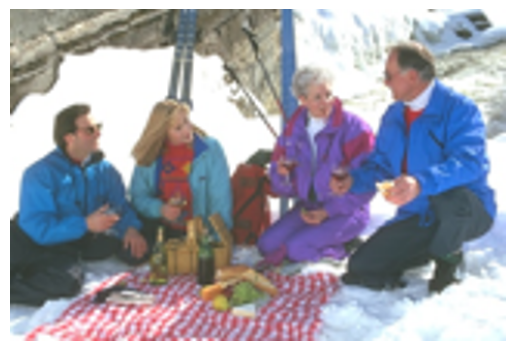

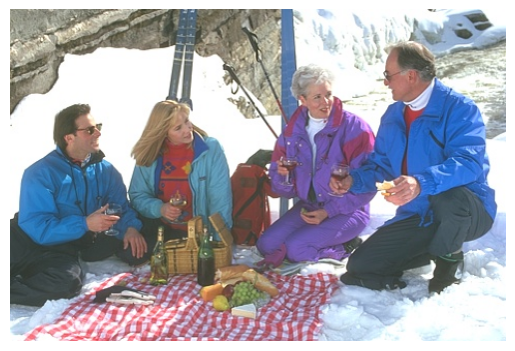

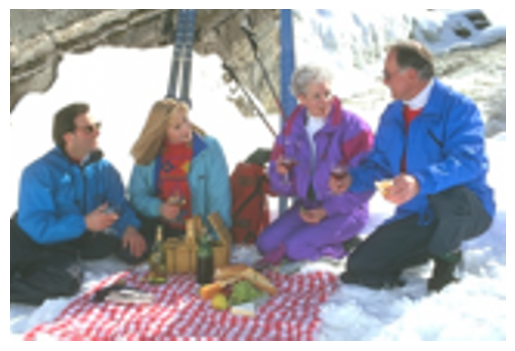

(481, 321) 480 321
Start bicubic interpolation
It will take a little while...


PSNR of low resolution image and high resolution image is 26.2389
PSNR of predict and high resolution is 23.6111


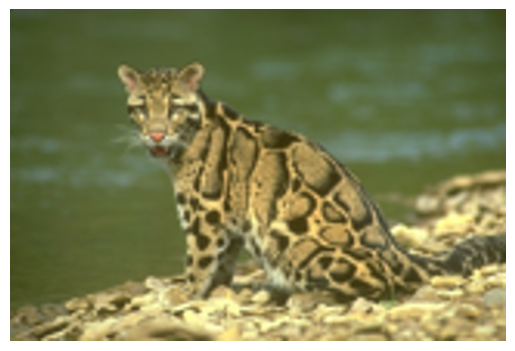

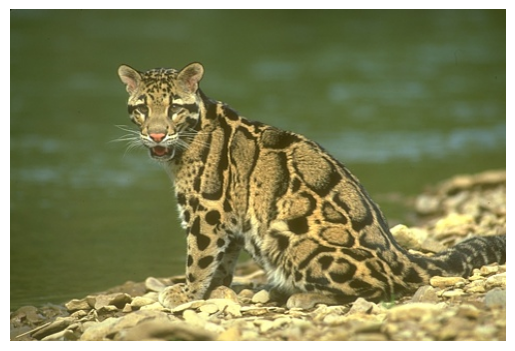

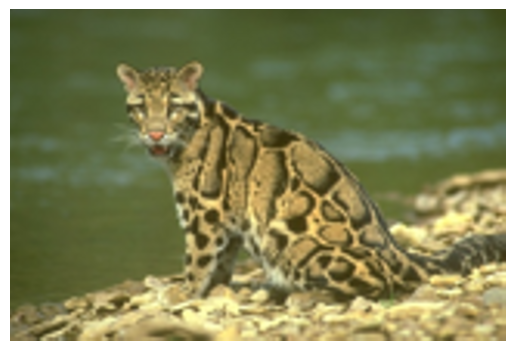

(481, 321) 480 321
Start bicubic interpolation
It will take a little while...


PSNR of low resolution image and high resolution image is 23.3867
PSNR of predict and high resolution is 21.1378


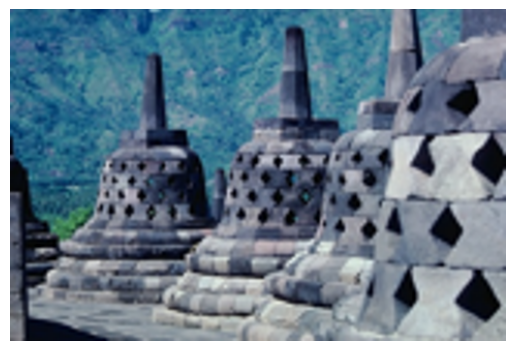

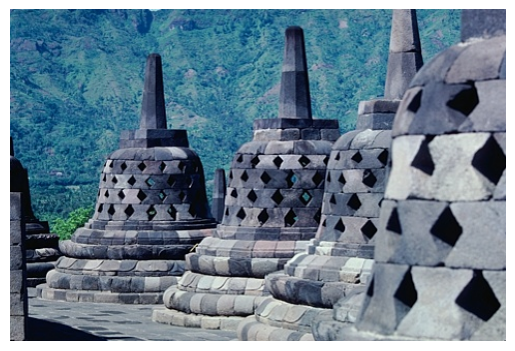

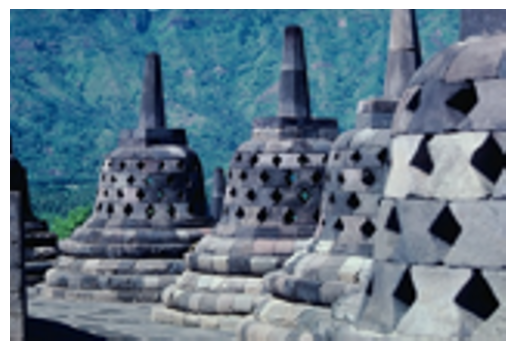

Avg. PSNR of lowres images is 26.1879
Avg. PSNR of reconstructions is 23.7438


In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths):
  if index in [50, 51, 56, 93]:
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor

    print(img.size, w, h)
    print
    highres_img = img.resize((w, h))
    a = -1/2
    lowres_input_arr = img_to_array(lowres_input)
    prediction = bicubic(lowres_input_arr, upscale_factor, a)
    #prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plt.figure()
    plt.imshow(lowres_img)
    plt.axis("off")
    plt.show()

    plt.figure()
    plt.imshow(highres_img)
    plt.axis("off")
    plt.show()

    plt.figure()
    plt.imshow(prediction/255)
    plt.axis("off")
    plt.show()

    #plot_results(lowres_img, index, "lowres")
    #plot_results(highres_img, index, "highres")
    #plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 4))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 4))